In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, roc_auc_score
from scipy.ndimage.filters import uniform_filter1d
from keras.models import Sequential, Model
from keras.layers import Conv1D, MaxPool1D, Dense, Dropout, Flatten, \
BatchNormalization, Input, Activation
from tensorflow.keras.optimizers import Adam

In [2]:
train_d = pd.read_csv("dataset/exoTrain.csv")

In [3]:
train_d.head()

,LABEL,FLUX.1,FLUX.2,FLUX.3,FLUX.4,FLUX.5,FLUX.6,FLUX.7,FLUX.8,FLUX.9,...,FLUX.3188,FLUX.3189,FLUX.3190,FLUX.3191,FLUX.3192,FLUX.3193,FLUX.3194,FLUX.3195,FLUX.3196,FLUX.3197
0,2,93.85,83.81,20.10,-26.98,-39.56,-124.71,-135.18,-96.27,-79.89,...,-78.07,-102.15,-102.15,25.13,48.57,92.54,39.32,61.42,5.08,-39.54
1,2,-38.88,-33.83,-58.54,-40.09,-79.31,-72.81,-86.55,-85.33,-83.97,...,-3.28,-32.21,-32.21,-24.89,-4.86,0.76,-11.70,6.46,16.00,19.93
2,2,532.64,535.92,513.73,496.92,456.45,466.00,464.50,486.39,436.56,...,-71.69,13.31,13.31,-29.89,-20.88,5.06,-11.80,-28.91,-70.02,-96.67
3,2,326.52,347.39,302.35,298.13,317.74,312.70,322.33,311.31,312.42,...,5.71,-3.73,-3.73,30.05,20.03,-12.67,-8.77,-17.31,-17.35,13.98
4,2,-1107.21,-1112.59,-1118.95,-1095.10,-1057.55,-1034.48,-998.34,-1022.71,-989.57,...,-594.37,-401.66,-401.66,-357.24,-443.76,-438.54,-399.71,-384.65,-411.79,-510.54


In [4]:
train_d.shape

(5087, 3198)

In [5]:
train_d.isnull().sum()

LABEL        0
FLUX.1       0
FLUX.2       0
FLUX.3       0
FLUX.4       0
            ..
FLUX.3193    0
FLUX.3194    0
FLUX.3195    0
FLUX.3196    0
FLUX.3197    0
Length: 3198, dtype: int64

In [6]:
train_d['LABEL'].value_counts()

1    5050
2      37
Name: LABEL, dtype: int64

In [7]:
categ = {2: 1, 1: 0}
train_d.LABEL = [categ[item] for item in train_d.LABEL]

In [8]:
train_d['LABEL'].value_counts()

0    5050
1      37
Name: LABEL, dtype: int64

<AxesSubplot:xlabel='LABEL', ylabel='count'>

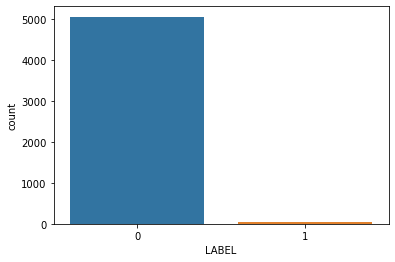

In [9]:
sns.countplot(x=train_d['LABEL'])

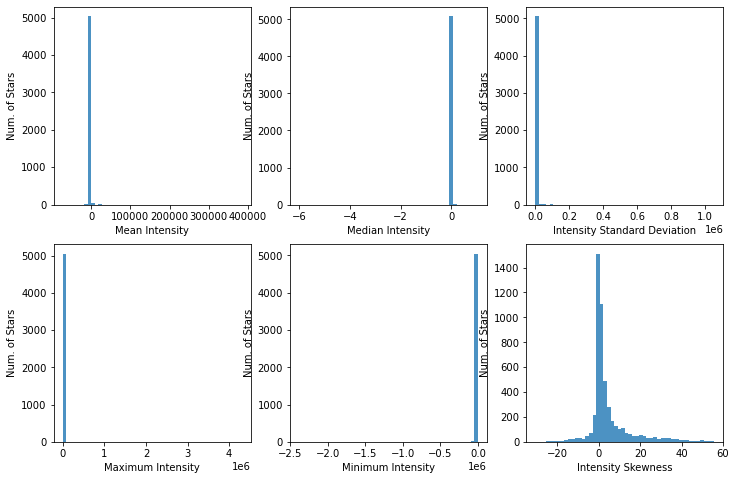

In [12]:
def stats_plots(train_d):
    means = train_d.mean(axis=1)
    medians = train_d.median(axis=1)
    std = train_d.std(axis=1)
    maxval = train_d.max(axis=1)
    minval = train_d.min(axis=1)
    skew = train_d.skew(axis=1)
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(231)
    ax.hist(means,alpha=0.8,bins=50)
    ax.set_xlabel('Mean Intensity')
    ax.set_ylabel('Num. of Stars')
    ax = fig.add_subplot(232)
    ax.hist(medians,alpha=0.8,bins=50)
    ax.set_xlabel('Median Intensity')
    ax.set_ylabel('Num. of Stars')
    ax = fig.add_subplot(233)
    ax.hist(std,alpha=0.8,bins=50)
    ax.set_xlabel('Intensity Standard Deviation')
    ax.set_ylabel('Num. of Stars')
    ax = fig.add_subplot(234)
    ax.hist(maxval,alpha=0.8,bins=50)
    ax.set_xlabel('Maximum Intensity')
    ax.set_ylabel('Num. of Stars')
    ax = fig.add_subplot(235)
    ax.hist(minval,alpha=0.8,bins=50)
    ax.set_xlabel('Minimum Intensity')
    ax.set_ylabel('Num. of Stars')
    ax = fig.add_subplot(236)
    ax.hist(skew,alpha=0.8,bins=50)
    ax.set_xlabel('Intensity Skewness')
    ax.set_ylabel('Num. of Stars')

stats_plots(train_d)
plt.show()

In [13]:
train_d.drop(train_d[train_d['FLUX.1']>250000].index, axis=0, inplace=True)

In [14]:
x_train = train_d.drop(["LABEL"],axis=1)
y_train = train_d["LABEL"]

In [15]:
from scipy import ndimage
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import recall_score, precision_score, classification_report,accuracy_score,confusion_matrix

In [16]:
x_train = normalized = normalize(x_train)

In [17]:
x_train = filtered = ndimage.filters.gaussian_filter(x_train, sigma=10)

In [18]:
std_scaler = StandardScaler()
x_train = scaled = std_scaler.fit_transform(x_train)

In [19]:
from sklearn.decomposition import PCA
pca = PCA() 
x_train = pca.fit_transform(x_train)
x_train = pca.transform(x_train)
total=sum(pca.explained_variance_)
k=0
current_variance=0
while current_variance/total < 0.90:
    current_variance += pca.explained_variance_[k]
    k=k+1
print(k)

37


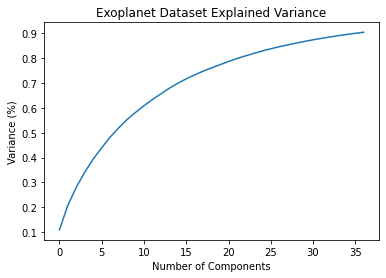

In [20]:
pca = PCA(n_components=37)
x_train = pca.fit_transform(x_train)
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') 
plt.title('Exoplanet Dataset Explained Variance')
plt.show()

<AxesSubplot:xlabel='index'>

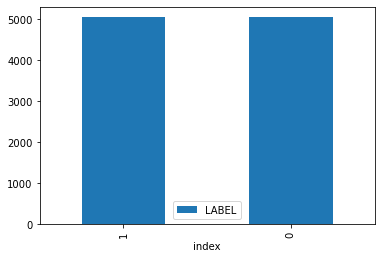

In [21]:
from imblearn.over_sampling import SMOTE
model = SMOTE()
ov_train_x,ov_train_y = model.fit_resample(train_d.drop('LABEL',axis=1), train_d['LABEL'])
ov_train_y = ov_train_y.astype('int')

ov_train_y.value_counts().reset_index().plot(kind='bar', x='index', y='LABEL')

In [22]:
train_X, test_X, train_y, test_y = train_test_split(ov_train_x, ov_train_y, test_size=0.33, random_state=42)

In [23]:
test_data = pd.read_csv("dataset/exoTest.csv")

In [24]:
test_data.LABEL = [categ[item] for item in test_data.LABEL]

In [25]:
train_X.shape

(6765, 3197)

In [26]:
test_data.shape

(570, 3198)

In [27]:
test_X.shape

(3333, 3197)

In [28]:
n_features = train_X.shape[1]

In [29]:
n_features

3197

In [30]:
import keras
from keras.layers import *
from keras.models import *
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dense, LeakyReLU
from tensorflow.keras.layers import Flatten, Activation, BatchNormalization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import layers
import tensorflow as tf

In [31]:
train_X.shape

(6765, 3197)

In [32]:
train_X.shape[1:]

(3197,)

In [33]:
model = Sequential()
model.add(Conv1D(filters=16, kernel_size=2, activation='relu', input_shape=(3197,1), kernel_regularizer='l2'))
model.add(Conv1D(filters=16, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2, strides=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dropout(0.4))
model.add(Dense(48, activation="relu"))
model.add(Dense(18, activation="relu"))
model.add(Dense(1, activation="sigmoid"))

In [34]:
x_test, y_test = test_data.drop(columns = ['LABEL']), test_data.loc[:, 'LABEL']

In [35]:
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.models import load_model
#from itertools import chain
model.compile(optimizer = Adam(4e-5), loss='binary_crossentropy', metrics=['accuracy'])

    # Fit model
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True)
history = model.fit(train_X, train_y, validation_split = 0.2, batch_size=128, callbacks=[early_stop], epochs=40, verbose=2)

    # Evaluate the model
train_acc = model.evaluate(train_X, train_y, verbose=2)
test_acc = model.evaluate(test_X, test_y, verbose=2)

Epoch 1/40
43/43 - 13s - loss: 14.6544 - accuracy: 0.5811 - val_loss: 1.6232 - val_accuracy: 0.7310 - 13s/epoch - 295ms/step
Epoch 2/40
43/43 - 9s - loss: 5.6544 - accuracy: 0.6571 - val_loss: 0.8564 - val_accuracy: 0.8004 - 9s/epoch - 207ms/step
Epoch 3/40
43/43 - 9s - loss: 9.2137 - accuracy: 0.6816 - val_loss: 2.6892 - val_accuracy: 0.8507 - 9s/epoch - 207ms/step
Epoch 4/40
43/43 - 9s - loss: 2.6449 - accuracy: 0.7452 - val_loss: 1.9890 - val_accuracy: 0.8115 - 9s/epoch - 202ms/step
Epoch 5/40
43/43 - 9s - loss: 3.3102 - accuracy: 0.7465 - val_loss: 3.4978 - val_accuracy: 0.9327 - 9s/epoch - 200ms/step
Epoch 6/40
43/43 - 9s - loss: 1.4160 - accuracy: 0.8001 - val_loss: 0.3218 - val_accuracy: 0.9497 - 9s/epoch - 203ms/step
Epoch 7/40
43/43 - 9s - loss: 1.7210 - accuracy: 0.8226 - val_loss: 0.8079 - val_accuracy: 0.9446 - 9s/epoch - 203ms/step
Epoch 8/40
43/43 - 9s - loss: 1.4500 - accuracy: 0.8160 - val_loss: 0.2226 - val_accuracy: 0.9653 - 9s/epoch - 201ms/step
Epoch 9/40
43/43 - 9s

In [36]:
def prediction_metrics(y_test, y_pred, y_class_pred, matrix):
    FP = matrix[0][1] 
    FN = matrix[1][0]
    TP = matrix[1][1]
    TN = matrix[0][0]

    sens = TP/(TP+FN)
    spec = TN/(TN+FP) 
    g_mean = np.sqrt(sens * spec)

    accuracy = accuracy_score(y_test, y_class_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_class_pred)
    precision = precision_score(y_test, y_class_pred)
    recall = recall_score(y_test, y_class_pred)
    f1 = f1_score(y_test, y_class_pred)
    auc = roc_auc_score(y_test, y_pred)

    print('\t\t Prediction Metrics\n')
    print("Accuracy:\t", "{:0.3f}".format(accuracy))
    print("Precision:\t", "{:0.3f}".format(precision))
    print("Recall:\t\t", "{:0.3f}".format(recall))
    print("\nF1 Score:\t", "{:0.3f}".format(f1))
    print("ROC AUC:\t", "{:0.3f}".format(auc))
    print("Balanced\nAccuracy:\t", "{:0.3f}".format(balanced_accuracy))
    print("\nSensitivity:\t", "{:0.3f}".format(sens))
    print("Specificity:\t", "{:0.3f}".format(spec))
    print("Geometric Mean:\t", "{:0.3f}".format(g_mean))

In [37]:
def conf_matrix(y_test, y_pred):

    matrix = confusion_matrix(y_test, y_pred)
    df_cm = pd.DataFrame(matrix, columns=[0, 1], index = [0, 1])
    df_cm.index.name = 'Truth'
    df_cm.columns.name = 'Predicted'
    plt.figure(figsize = (10,7))
    sns.set(font_scale=1.4) 
    sns.heatmap(df_cm, cmap="BuGn", annot=True, annot_kws={"size": 16})
    plt.show()
    
    return matrix

In [38]:
def graph_acc(history):
    # Plot loss during training
    plt.subplot(211)
    plt.title('Loss')
    plt.plot(history.history['loss'], label='train')
    plt.plot(history.history['val_loss'], label='test')
    plt.legend()

    # Plot accuracy during training
    plt.subplot(212)
    plt.title('Accuracy')
    plt.plot(history.history['accuracy'], label='train')
    plt.plot(history.history['val_accuracy'], label='test')
    plt.legend()
    plt.show()

In [39]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

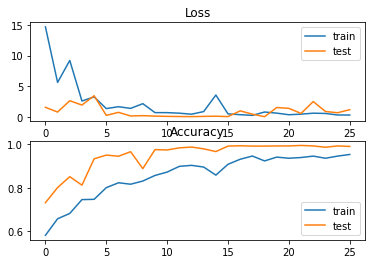

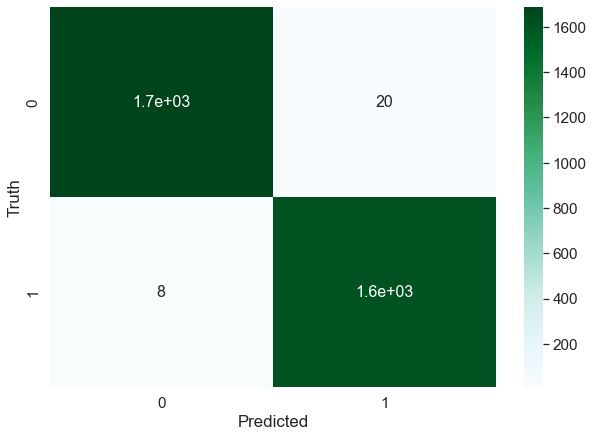

		 Prediction Metrics

Accuracy:	 0.992
Precision:	 0.988
Recall:		 0.995

F1 Score:	 0.991
ROC AUC:	 0.995
Balanced
Accuracy:	 0.992

Sensitivity:	 0.995
Specificity:	 0.988
Geometric Mean:	 0.992


In [40]:
y_class_pred = (model.predict(test_X) > 0.5).astype("int32")
y_pred = model.predict(test_X)

    # Accuracy graph
graph_acc(history)

    # Confustion matrix
matrix = conf_matrix(test_y, y_class_pred)

    # Metrics
prediction_metrics(test_y, y_pred, y_class_pred, matrix)

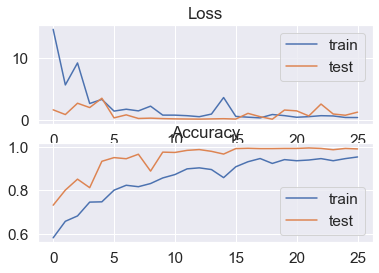

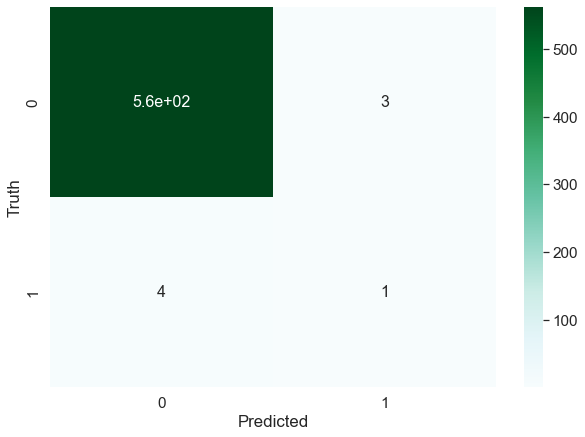

		 Prediction Metrics

Accuracy:	 0.988
Precision:	 0.250
Recall:		 0.200

F1 Score:	 0.222
ROC AUC:	 0.553
Balanced
Accuracy:	 0.597

Sensitivity:	 0.200
Specificity:	 0.995
Geometric Mean:	 0.446


In [41]:
y_class_pred = (model.predict(x_test) > 0.5).astype("int32")
y_pred = model.predict(x_test)

    # Accuracy graph
graph_acc(history)

    # Confustion matrix
matrix = conf_matrix(y_test, y_class_pred)

    # Metrics
prediction_metrics(y_test, y_pred, y_class_pred, matrix)

In [42]:
_, accuracy = model.evaluate(x_test, y_test, batch_size=2048, verbose=0)

In [43]:
_, ay = model.evaluate(test_X, test_y, batch_size=2048, verbose=0)

In [44]:
ay

0.9915991425514221

In [45]:
accuracy

0.9877192974090576

In [46]:
score = accuracy * 100.0
score

98.77192974090576

In [47]:
test_y.shape

(3333,)

In [48]:
pred = model.predict(x_test)

In [49]:
pred

array([[5.72635829e-01],
       [8.16922494e-08],
       [2.36945152e-02],
       [1.48055801e-09],
       [4.72079949e-13],
       [8.54573846e-02],
       [9.83694804e-07],
       [6.43014908e-04],
       [1.69332066e-11],
       [1.88372280e-06],
       [9.58539295e-06],
       [2.65663829e-07],
       [1.05181336e-01],
       [5.81684834e-09],
       [1.76918206e-06],
       [6.41106367e-02],
       [1.23888254e-04],
       [1.43428743e-02],
       [3.93823087e-02],
       [6.77040219e-03],
       [6.24290109e-03],
       [0.00000000e+00],
       [2.50791609e-02],
       [7.43353367e-03],
       [3.84232402e-03],
       [6.11054904e-15],
       [9.31734443e-02],
       [1.88469887e-04],
       [2.87101398e-10],
       [8.70436430e-04],
       [1.69749583e-07],
       [7.07704127e-02],
       [1.88555121e-02],
       [2.35259533e-03],
       [6.59127730e-09],
       [1.58270987e-12],
       [4.47428138e-05],
       [0.00000000e+00],
       [1.59383416e-01],
       [4.99935986e-08],


In [50]:
y_test

0      1
1      1
2      1
3      1
4      1
      ..
565    0
566    0
567    0
568    0
569    0
Name: LABEL, Length: 570, dtype: int64

### using ml models

In [51]:
def mmodel(classifier,dtrain_x,dtrain_y,dtest_x,dtest_y):
    classifier.fit(dtrain_x,dtrain_y)

    prediction=classifier.predict(dtest_x)

    print('Validation accuracy of model is', accuracy_score(prediction,dtest_y))
    print ("\nClassification report :\n",(classification_report(dtest_y,prediction)))

    plt.figure(figsize=(13,10))
    plt.subplot(221)
    sns.heatmap(confusion_matrix(dtest_y,prediction),annot=True,cmap="viridis",fmt = "d",linecolor="k",linewidths=3)
    plt.title("CONFUSION MATRIX",fontsize=20)

In [52]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import RandomOverSampler

Validation accuracy of model is 0.9747974797479748

Classification report :
               precision    recall  f1-score   support

           0       0.99      0.96      0.98      1709
           1       0.96      0.99      0.97      1624

    accuracy                           0.97      3333
   macro avg       0.97      0.98      0.97      3333
weighted avg       0.98      0.97      0.97      3333



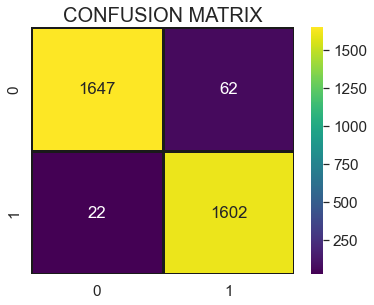

In [53]:
from sklearn.tree import DecisionTreeClassifier
ds_model = DecisionTreeClassifier(max_depth=12, random_state=13)
mmodel(ds_model,train_X,train_y,test_X,test_y)

Validation accuracy of model is 0.9993999399939995

Classification report :
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      1709
           1       1.00      1.00      1.00      1624

    accuracy                           1.00      3333
   macro avg       1.00      1.00      1.00      3333
weighted avg       1.00      1.00      1.00      3333



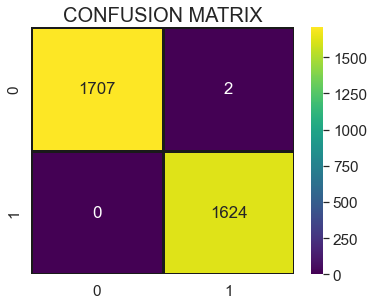

In [54]:
mmodel(RandomForestClassifier(), train_X, train_y, test_X, test_y)

In [55]:
from xgboost import XGBClassifier

xgb_classifier = XGBClassifier()
xgb_classifier.fit(train_X, train_y)
y_pred_xgb = xgb_classifier.predict(test_X)
accuracy_xgb = accuracy_score(test_y, y_pred_xgb)
print(accuracy_xgb)

0.9996999699969997
